# Deep Neural Network Tensorflow Model
* Data Source: https://www.kaggle.com/datasets/henryokam/prosper-loan-data?select=prosperLoanData.csv

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, precision_recall_curve, roc_auc_score)

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"sklearn\.utils\.deprecation",
    message=r".*force_all_finite.*"
)

In [2]:
# Read input data
# sourced  and converted to parquet from: https://www.kaggle.com/datasets/henryokam/prosper-loan-data?select=prosperLoanData.csv
df = pd.read_parquet('C:/ML/datasets/ProsperData/prosperLoanData.parquet')

print(f"Input data shape: {df.shape}")
df.info()

Input data shape: (113937, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-nu

In [3]:
# Data head
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,None,36,Current,None,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,None,36,Current,None,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,None,36,Current,None,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [4]:
# Dropping all entries with loan statuses not in focus
df = df[df['LoanStatus'] != 'Cancelled']
df = df[df['LoanStatus'] != 'Current']
df = df[df["LoanStatus"] != "FinalPaymentInProgress"]
df = df[df["LoanStatus"] != "Past Due (1-15 days)"]
df = df[df["LoanStatus"] != "Past Due (16-30 days)"]
df = df[df["LoanStatus"] != "Past Due (31-60 days)"]
df = df[df["LoanStatus"] != "Past Due (61-90 days)"]
df = df[df["LoanStatus"] != "Past Due (91-120 days)"]
df = df[df["LoanStatus"] != "Past Due (>120 days)"]
df = df[df["LoanStatus"] != "Chargedoff"]

# Pick the most relevant features that don't introduce data leakage
df = df[['CreditGrade', 'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'DateCreditPulled', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors']]

# Encoding credit rating pull data to be relative to epoch and dropping original column
df['DateCreditPulled'] = pd.to_datetime(df['DateCreditPulled'], format='mixed', errors='coerce')
df['DateCreditCheckPulledEpoch'] = (df['DateCreditPulled'] - pd.Timestamp("1970-01-01")).dt.days
df = df.drop('DateCreditPulled', axis=1)

# Mapping loan satus to target function values and dropping original column
loanStatusMapping = { 'Completed': 0, 'Defaulted': 1 }
df['Default'] = df['LoanStatus'].map(loanStatusMapping)
df = df.drop('LoanStatus', axis=1)

# Encoding home ownership status and dropping original column
isBorrowerHomeownerMapping = { True: 1, False: 0 }
df['OwnsHome'] = df['IsBorrowerHomeowner'].map(isBorrowerHomeownerMapping)
df = df.drop('IsBorrowerHomeowner', axis=1)

# Encoding income range and dropping original column
incomeRangeMapping = { 'Not displayed':0, 'Not employed':0, '$0':0, '$1-24,999':1, '$25,000-49,999':2, '$50,000-74,999':3, '$75,000-99,999':4, '$100,000+':5 }
df['Income'] = df['IncomeRange'].map(incomeRangeMapping)
df = df.drop('IncomeRange', axis=1)

# Encoding income verifiable flag and dropping original column
incomeVerifiableMapping = { True: 1, False: 0 }
df['IncomeVerifiable'] = df['IncomeVerifiable'].map(incomeVerifiableMapping)
df = df.drop('IncomeVerifiable', axis=1)

# Encoding categorical attribute using one-hot vector
df = pd.get_dummies(df, columns=['EmploymentStatus'], drop_first=False)

# Dropping all columns with na values
columns_with_nan = df.columns[df.isna().any()].tolist()
df = df.drop(columns=columns_with_nan)

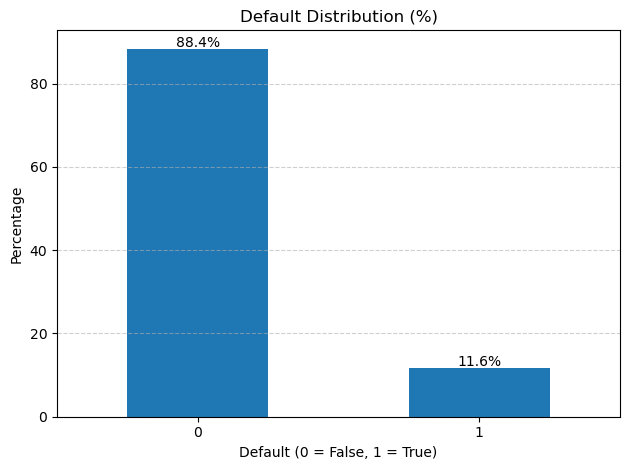

In [5]:
# Plot feature importance
X = df.drop(['Default'], axis=1)
y = df['Default']

X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

# Use a classifier to determine feature importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_encoded, y)

feature_importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot % split of Default vs Non-Default Loans
percentages = df['Default'].value_counts(normalize=True) * 100
percentages.plot(kind='bar')
plt.title('Default Distribution (%)')
plt.xlabel('Default (0 = False, 1 = True)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()


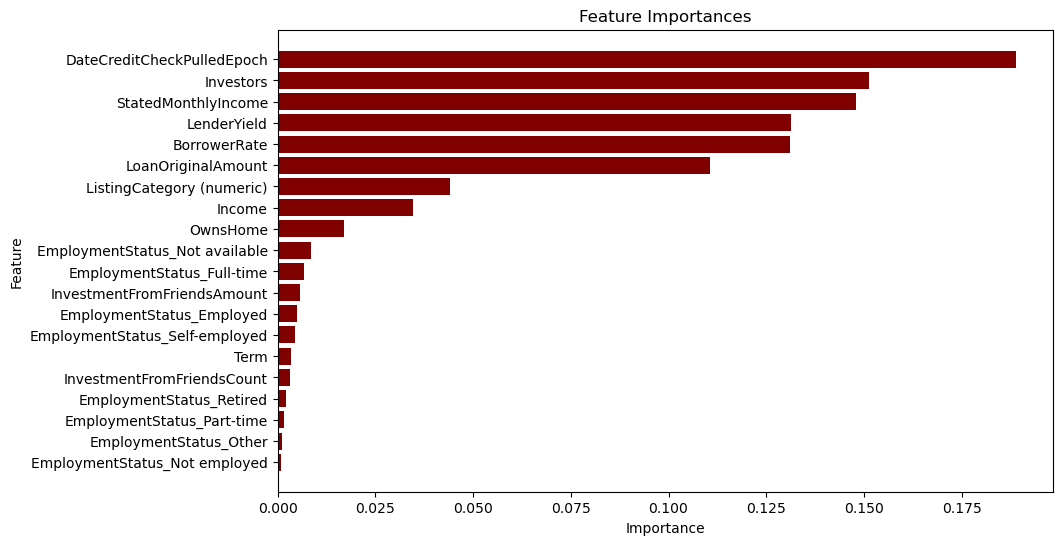

In [6]:
# Prepare X and y
X = df.drop(['Default'], axis=1)
y = df['Default']

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='maroon')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


In [7]:
# Create train / test set split (Optional: use SMOTE to balance train set and fight class imblance
def create_train_test(X, y, train_size, use_smote):
    input_df = pd.concat([X, y], axis=1)
    df_defaulted = input_df[input_df['Default'] == 1]
    df_completed = input_df[input_df['Default'] == 0]

    df_completed = df_completed.sample(n=df_defaulted.shape[0], random_state=42).copy()
    df_completed_trainLeftover = input_df.drop(df_completed.index)

    print(f"Leftover size: {df_completed_trainLeftover.shape}")
    
    combined_df = pd.concat([df_completed, df_defaulted], ignore_index=True)

    X_train, X_test, y_train, y_test = train_test_split(combined_df.drop('Default', axis=1), combined_df['Default'], train_size=0.8, random_state=42)

    # Optional step to fight class imbalance using SMOTE
    if use_smote:
        smote = SMOTE(random_state=42)

        df_train = pd.concat([X_train, y_train], axis=1)
        df_train = pd.concat([df_train, df_completed_trainLeftover], axis=0)
        
        X_train, y_train = smote.fit_resample(df_train.drop('Default', axis=1), df_train['Default'])
        print(f"After smote - X_train: {X_train.shape}, Y_train: {y_train.shape}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test(X, y, train_size=0.8, use_smote=False)


Leftover size: (38074, 21)


In [8]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit and transform train set
X_test = scaler.transform(X_test)        # only transform test set

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [9]:
# Make and compile DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [10]:
# Train the model
# Callbacks for early stopping and learning rate reduction
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=64,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100
126/126 [==============================] - 4s 13ms/step - loss: 0.7459 - accuracy: 0.6205 - precision: 0.6253 - recall: 0.5977 - val_loss: 0.6473 - val_accuracy: 0.6474 - val_precision: 0.6057 - val_recall: 0.8586 - lr: 3.0000e-04
Epoch 2/100
126/126 [==============================] - 2s 12ms/step - loss: 0.6914 - accuracy: 0.6597 - precision: 0.6611 - recall: 0.6529 - val_loss: 0.6193 - val_accuracy: 0.6818 - val_precision: 0.6394 - val_recall: 0.8437 - lr: 3.0000e-04
Epoch 3/100
126/126 [==============================] - 2s 13ms/step - loss: 0.6615 - accuracy: 0.6723 - precision: 0.6685 - recall: 0.6811 - val_loss: 0.6004 - val_accuracy: 0.6902 - val_precision: 0.6644 - val_recall: 0.7774 - lr: 3.0000e-04
Epoch 4/100
126/126 [==============================] - 2s 13ms/step - loss: 0.6623 - accuracy: 0.6695 - precision: 0.6670 - recall: 0.6748 - val_loss: 0.5950 - val_accuracy: 0.6982 - val_precision: 0.6769 - val_recall: 0.7666 - lr: 3.0000e-04
Epoch 5/100
126/126 [=======

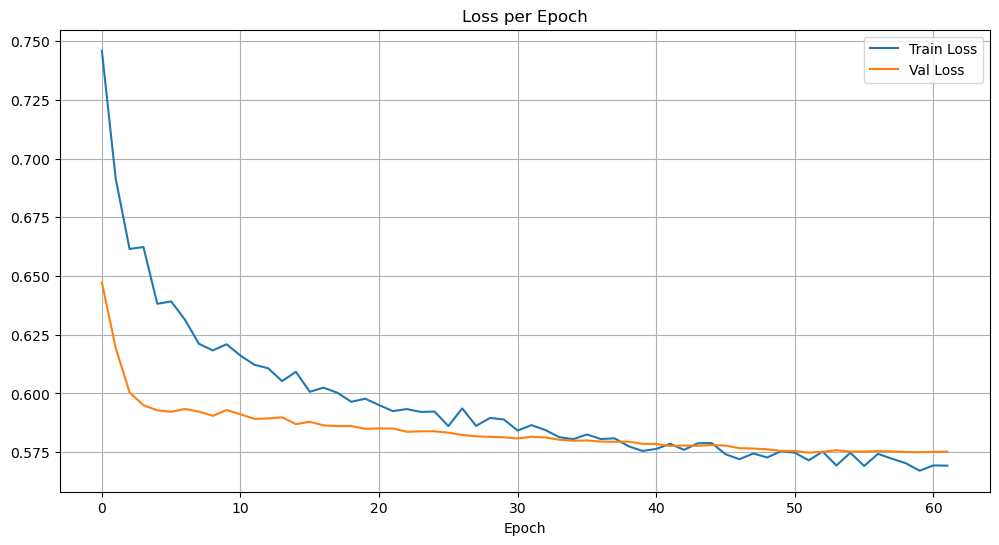

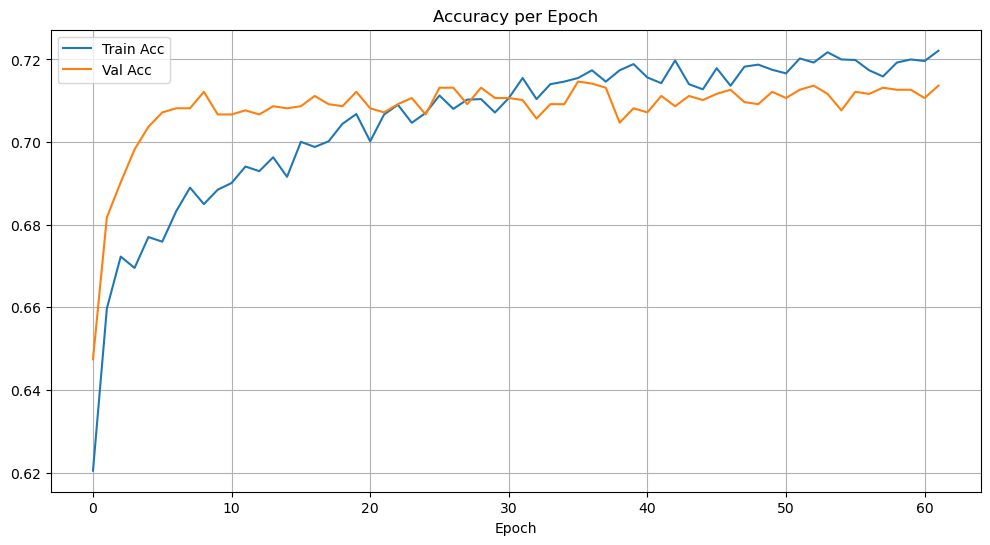

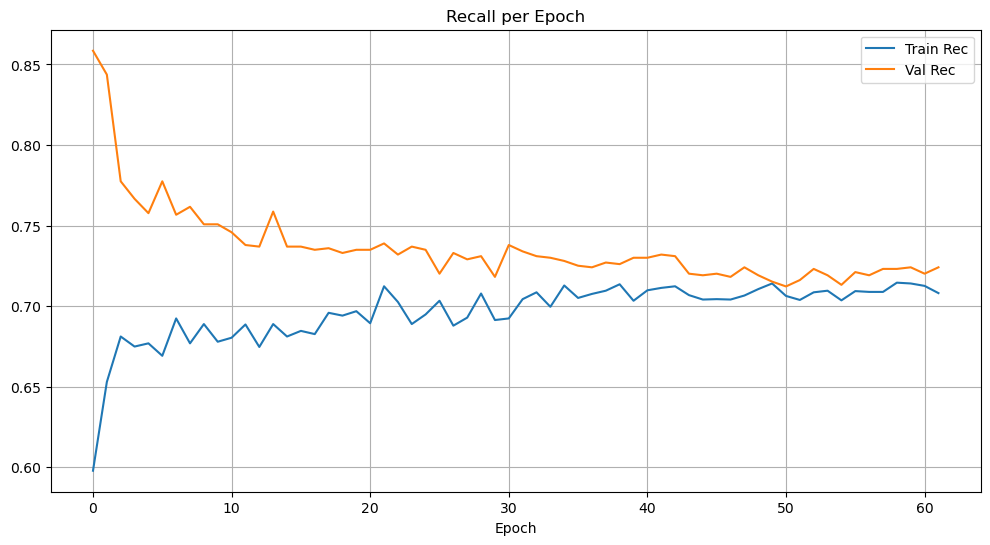

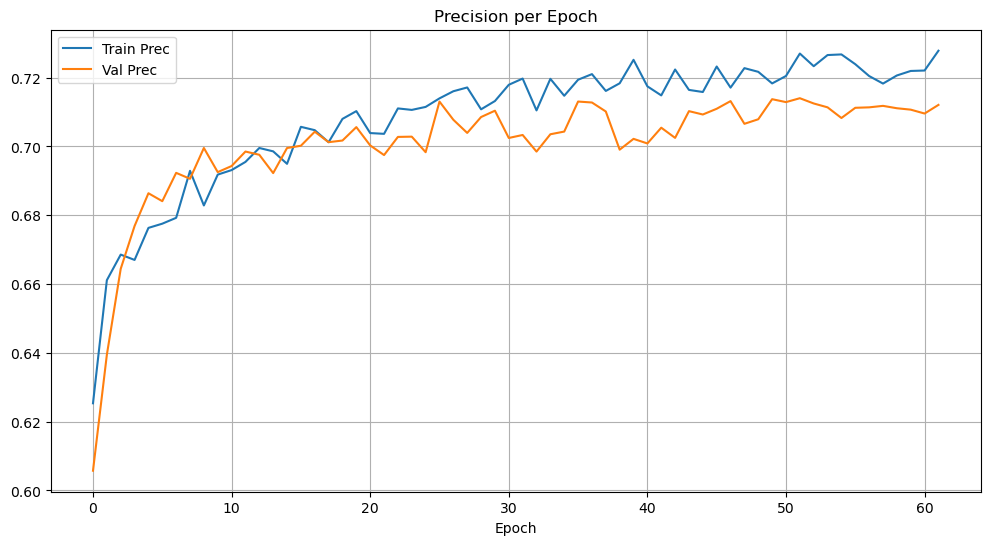

In [11]:
# Plot training/validation loss, accuracy, recall, and precision
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss per Epoch'); plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy per Epoch'); plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(history.history['recall'], label='Train Rec')
plt.plot(history.history['val_recall'], label='Val Rec')
plt.legend(); plt.title('Recall per Epoch'); plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(history.history['precision'], label='Train Prec')
plt.plot(history.history['val_precision'], label='Val Prec')
plt.legend(); plt.title('Precision per Epoch'); plt.xlabel('Epoch')
plt.show()


In [12]:
# Evaluate DNN model
y_prob = model.predict(X_test).ravel()

# PR‐AUC and threshold tuning
precision, recall, thresh = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
f1 = 2*precision*recall/(precision+recall+1e-8)
best_idx = np.argmax(f1)
best_thresh = thresh[best_idx]

print(f"PR‐AUC: {pr_auc:.3f}, Best threshold: {best_thresh:.2f}")


63/63 [==============================] - 0s 2ms/step
PR‐AUC: 0.785, Best threshold: 0.39


In [13]:
y_pred = (y_prob >= best_thresh).astype(int)
print(classification_report(y_test, y_pred, target_names=['Paid','Default']))


              precision    recall  f1-score   support

        Paid       0.79      0.53      0.64       997
     Default       0.65      0.86      0.74      1011

    accuracy                           0.70      2008
   macro avg       0.72      0.70      0.69      2008
weighted avg       0.72      0.70      0.69      2008



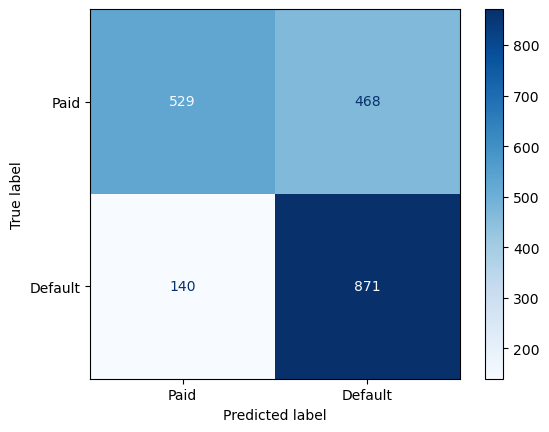

In [14]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Paid','Default']).plot(cmap='Blues')
plt.show()

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
print("NN ROC‐AUC:", auc(fpr,tpr))

NN ROC‐AUC: 0.7878888892195877


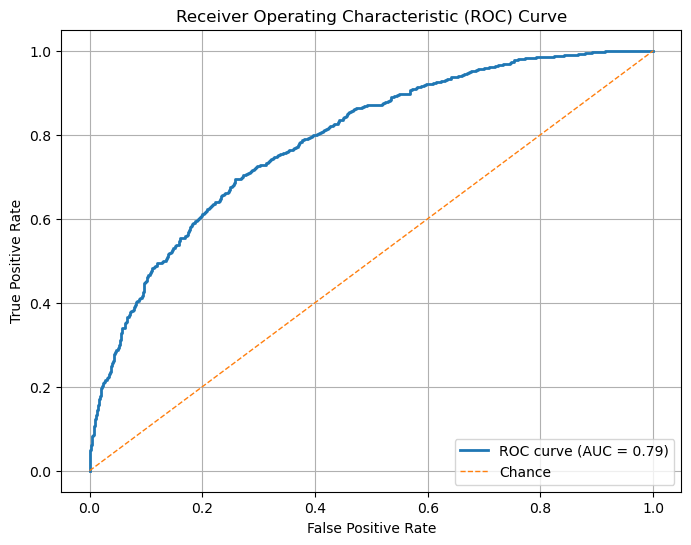

In [16]:
# Plot ROC curve'
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [17]:
print(f"Final NN ROC-AUC: {roc_auc:.4f}")
print(f"Final NN PR-AUC: {pr_auc:.4f}")
print(f"Best F1 Threshold: {best_thresh:.4f}")

Final NN ROC-AUC: 0.7879
Final NN PR-AUC: 0.7848
Best F1 Threshold: 0.3897
